# Libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import plot_tree

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


# Machine Learning models for exam

In [74]:
# Load the data
data = pd.read_csv('./cleaned_merged_course_data.csv')

# Convert 'Eksamensgennemsnit' to numeric and sort the data by 'Course code' and 'Year'
data['Eksamensgennemsnit'] = data['Eksamensgennemsnit'].str.replace(',', '.').astype(float)
data_sorted = data.sort_values(by=['Course code', 'Year'])

# Define the moving average as 3 periods
moving_average_period = 3

# Calculate the moving average for each 'Course code'
data_sorted['Moving_Average_GPA'] = data_sorted.groupby('Course code')['Eksamensgennemsnit'].transform(
    lambda x: x.rolling(window=moving_average_period, min_periods=1).mean()
)

# Save the DataFrame to a new CSV and Excel file
output_csv_path = './ML_data.csv'
data_sorted.to_csv(output_csv_path, index=False)

output_excel_path = './ML_data.xlsx'
data_sorted.to_excel(output_excel_path, index=False)


In [75]:
# Function to calculate the accuracy measure based on predicted values and test set
def accuracy(prediction,test):
    errors = abs(prediction - test_labels)
    mape_temp = 100 * abs(errors / test_labels)
    mape=np.mean(mape_temp[~np.isinf(mape_temp)])
    accuracy=100-mape
    MSE=np.mean(np.square(errors))
    print('MAE:', round(np.mean(errors), 5), 'grades.')
    print('MAPE:', round(mape, 5), '%.')
    print('Accuracy:', round(accuracy, 5), '%.')
    print('MSE:', round(MSE, 5))

In [76]:
# Define the WAC function
def WAC(x):
    return np.average(x.fillna(0), weights=Data.loc[x.index, 'Fremmødte'])

pd.set_option('display.max_columns', 50)

# Load the data
Data = pd.read_csv('ML_data.csv')

# Select what we want to use for the prediction and extract the labels
Input_values = Data[['Course code', 'Year', 'Season', 'Antal bestået', 'Antal tilmeldte', 
                     'Eksamensgennemsnit', 'Moving_Average_GPA', 'Fremmødte', 'Point( ECTS )', 'Kursustype', 
                     'Evalueringsform', 'Bedømmelsesform', 'Institut'] + Data.columns.tolist()[-11:]]

Output_values = np.array(Input_values['Eksamensgennemsnit'])

# Drop unnecessary columns
Input_values = Input_values.drop(['Season', 'Institut', 'Course code', 'Kursustype', 'Eksamensgennemsnit'], axis=1)
Input_values['Moving_Average_GPA'].fillna(WAC(Data['Eksamensgennemsnit']), inplace=True)
Input_values = pd.get_dummies(Input_values)

# Deduplicate the columns
Input_values = Input_values.loc[:, ~Input_values.columns.duplicated()]

# Save column headers
Input_values_list = list(Input_values.columns)

# Convert the dataframe to a numpy array
Input_values = np.array(Input_values)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(
    Input_values, Output_values, test_size=0.30, random_state=1)

# Print the shapes of the resulting datasets
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (5033, 38)
Training Labels Shape: (5033,)
Testing Features Shape: (2158, 38)
Testing Labels Shape: (2158,)


## Ordinary Least Squares (OLS) Regression

In [77]:
#Scale data
scaler=StandardScaler().fit(train_features)
sc_train_features=scaler.transform(train_features)
sc_test_features=scaler.transform(test_features)

In [78]:
#Fit OLS model on the training data
ols=linear_model.LinearRegression()
ols.fit(sc_train_features,train_labels)

#Predict
predict_ols = ols.predict(sc_test_features)
accuracy(predict_ols, test_labels)

MAE: 0.48113 grades.
MAPE: 8.8107 %.
Accuracy: 91.1893 %.
MSE: 0.53049


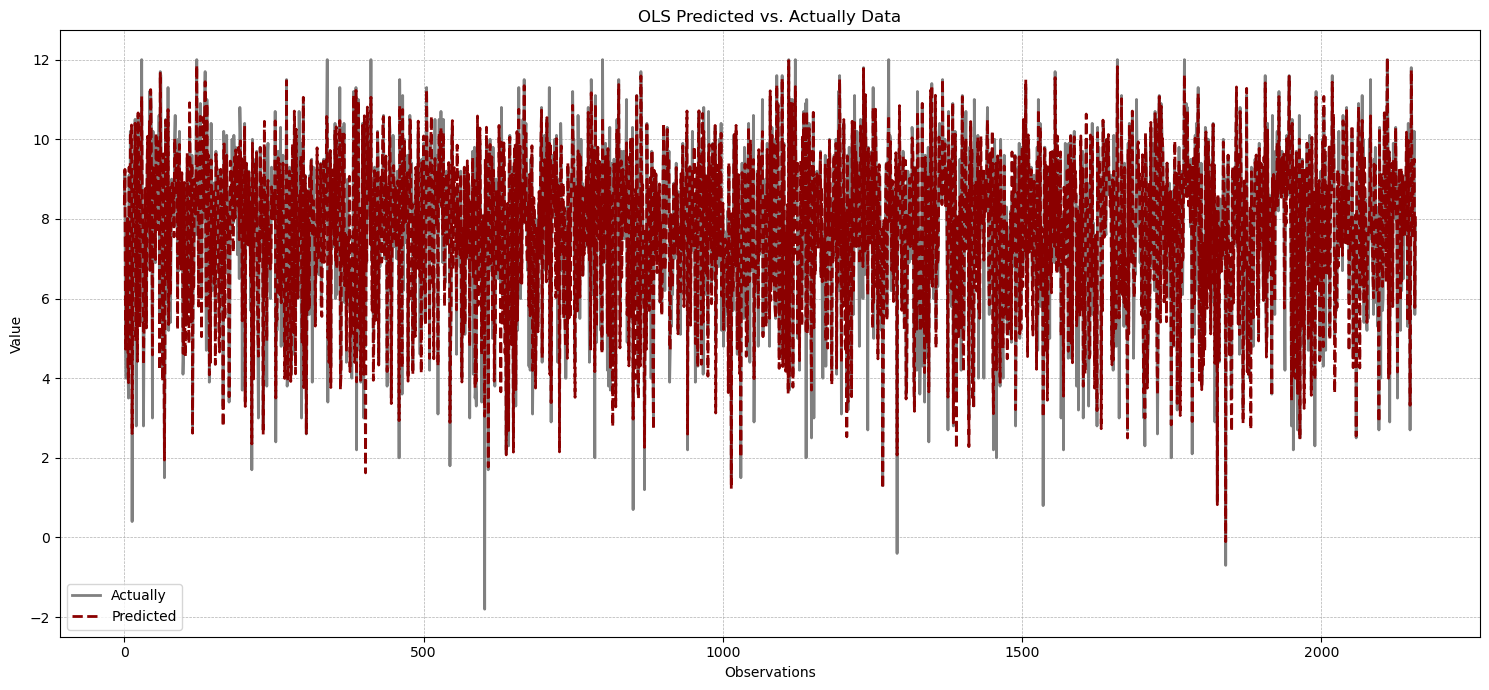

In [79]:
# Create an array of numbers for the x-axis based on the length of the data
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Actually', color='gray', linewidth=2)
plt.plot(x_axis, predict_ols, label='Predicted', color='darkred', linestyle='--', linewidth=2)
plt.title('OLS Predicted vs. Actually Data')
plt.xlabel('Observations')
plt.ylabel('Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Lasso

In [80]:
#Fit the lasso model and predict using standardized alpha
lasso_reg=Lasso()
lasso_reg.fit(sc_train_features,train_labels)
lasso_predict=lasso_reg.predict(sc_test_features)
accuracy(lasso_predict, test_labels)

MAE: 0.97584 grades.
MAPE: 19.23315 %.
Accuracy: 80.76685 %.
MSE: 1.57765


In [81]:
#Use GridSearch to find optimal size of hyperparameter
lasso_reg=Lasso()
param_grid={'alpha':np.logspace(-4,4,12)}
grid_search_lasso = GridSearchCV(estimator = lasso_reg, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_lasso.fit(sc_train_features,train_labels)
grid_search_lasso.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/clarajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.041e+02, tolerance: 1.768e+00
  model = cd_fast.enet_coordinate_descent(
/Users/clarajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.827e+02, tolerance: 1.775e+00
  model = cd_fast.enet_coordinate_descent(
/Users/clarajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .........................alpha=0.002848035868435802; total time=   0.0s
[CV] END .........................alpha=0.002848035868435802; total time=   0.0s
[CV] END .........................alpha=0.002848035868435802; total time=   0.0s
[CV] END .........................alpha=0.002848035868435802; total time=   0.0s
[CV] END .........................alpha=0.002848035868435802; total time=   0.0s
[CV] END ..........................alpha=0.01519911082952933; total time=   0.0s
[CV] END ..........................alpha=0.01519911082952933; total time=   0.0s
[CV] END ...................

/Users/clarajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e+01, tolerance: 1.768e+00
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.002848035868435802}

In [82]:
#Fit the new lasso model and predict
best_grid_lasso = grid_search_lasso.best_estimator_ 
predictions_best_grid_lasso = best_grid_lasso.predict(sc_test_features)
accuracy(predictions_best_grid_lasso, test_labels)

MAE: 0.47804 grades.
MAPE: 8.7898 %.
Accuracy: 91.2102 %.
MSE: 0.53281


### Plot of Lasso predictions

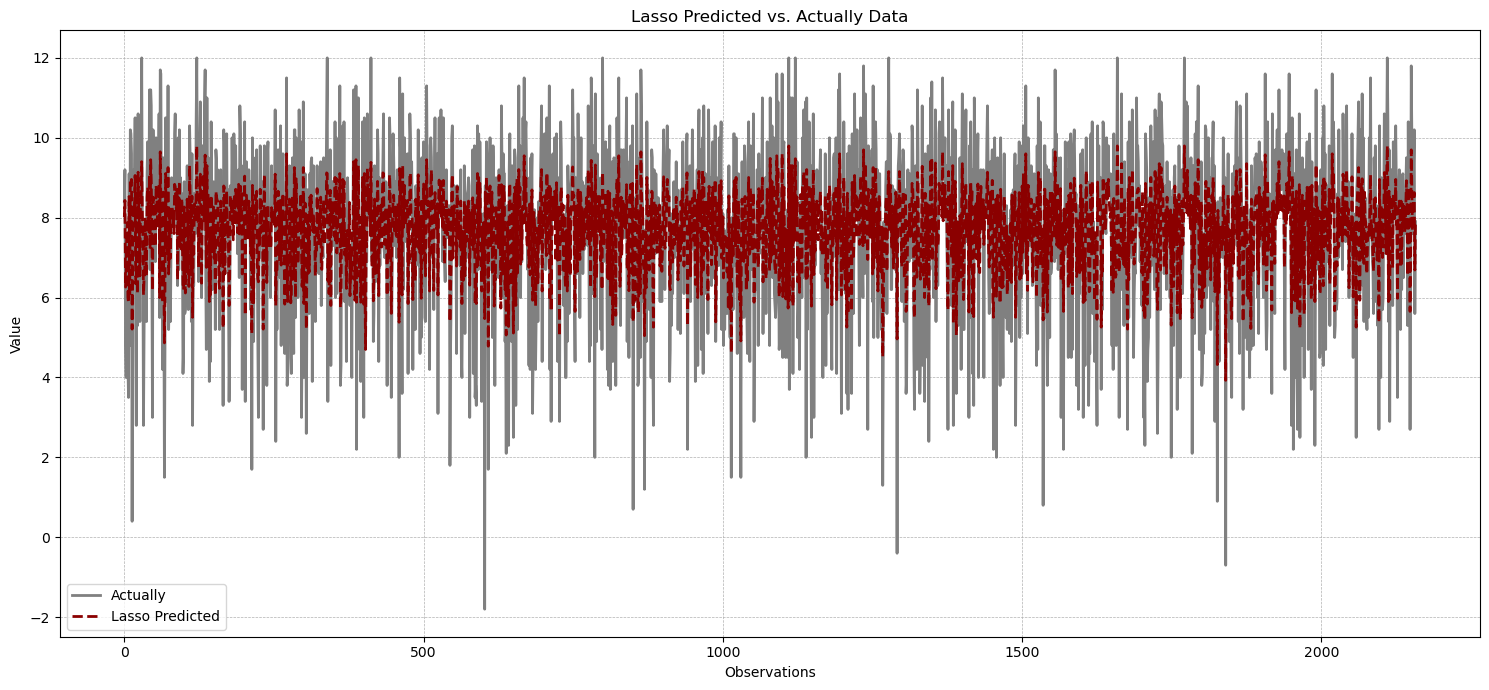

In [83]:
# Plot Lasso predictions
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Actually', color='gray', linewidth=2)
plt.plot(x_axis, lasso_predict, label='Lasso Predicted', color='darkred', linestyle='--', linewidth=2)
plt.title('Lasso Predicted vs. Actually Data')
plt.xlabel('Observations')
plt.ylabel('Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Coefficients from Lasso

In [84]:
# Use coefficients from the optimal Lasso model and create DataFrame
lasso_coefficients = best_grid_lasso.coef_

coeff_df_lasso = pd.DataFrame(lasso_coefficients, Input_values_list, columns=['Coefficient'])
coeff_df_lasso = coeff_df_lasso.sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)

# Display the top and bottom 5 rows 
top_5 = coeff_df_lasso.head()
bottom_5 = coeff_df_lasso.tail()
top_and_bottom_5 = pd.concat([top_5, bottom_5])
top_and_bottom_5

,Coefficient
Moving_Average_GPA,1.937575
Antal bestået,0.269202
Fremmødte,-0.216922
Year,-0.032100
Point( ECTS )_15,0.014308
Mulighed for GRØN DYST deltagelse_Ja,-0.000000
Mulighed for GRØN DYST deltagelse_Måske,0.000000
Antal tilmeldte,-0.000000
Point( ECTS )_2,0.000000
"Point( ECTS )_12,5",0.000000


## Ridge

In [85]:
#Fit the Ridge model and predict using standardized alpha
Ridge_reg=Ridge()
Ridge_reg.fit(sc_train_features,train_labels)
Ridge_predict=Ridge_reg.predict(sc_test_features)
accuracy(Ridge_predict, test_labels)

MAE: 0.48062 grades.
MAPE: 8.80485 %.
Accuracy: 91.19515 %.
MSE: 0.53044


In [86]:
#Use GridSearch to find optimal size of hyperparameter
Ridge_reg=Ridge()
param_grid={'alpha':np.logspace(-5,5,50)}
grid_search_Ridge = GridSearchCV(estimator = Ridge_reg, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_Ridge.fit(sc_train_features,train_labels)
grid_search_Ridge.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END ........................alpha=2.559547922699533e-05; total time=   0.0s
[CV] END ........................alpha=2.559547

{'alpha': 5.1794746792312125}

In [87]:
# Fit the new Ridge model with theoptimal hyperparameter and predic
best_grid_Ridge = grid_search_Ridge.best_estimator_
predictions_best_grid_Ridge = best_grid_Ridge.predict(sc_test_features)
accuracy(predictions_best_grid_Ridge, test_labels)

MAE: 0.47982 grades.
MAPE: 8.79368 %.
Accuracy: 91.20632 %.
MSE: 0.53066


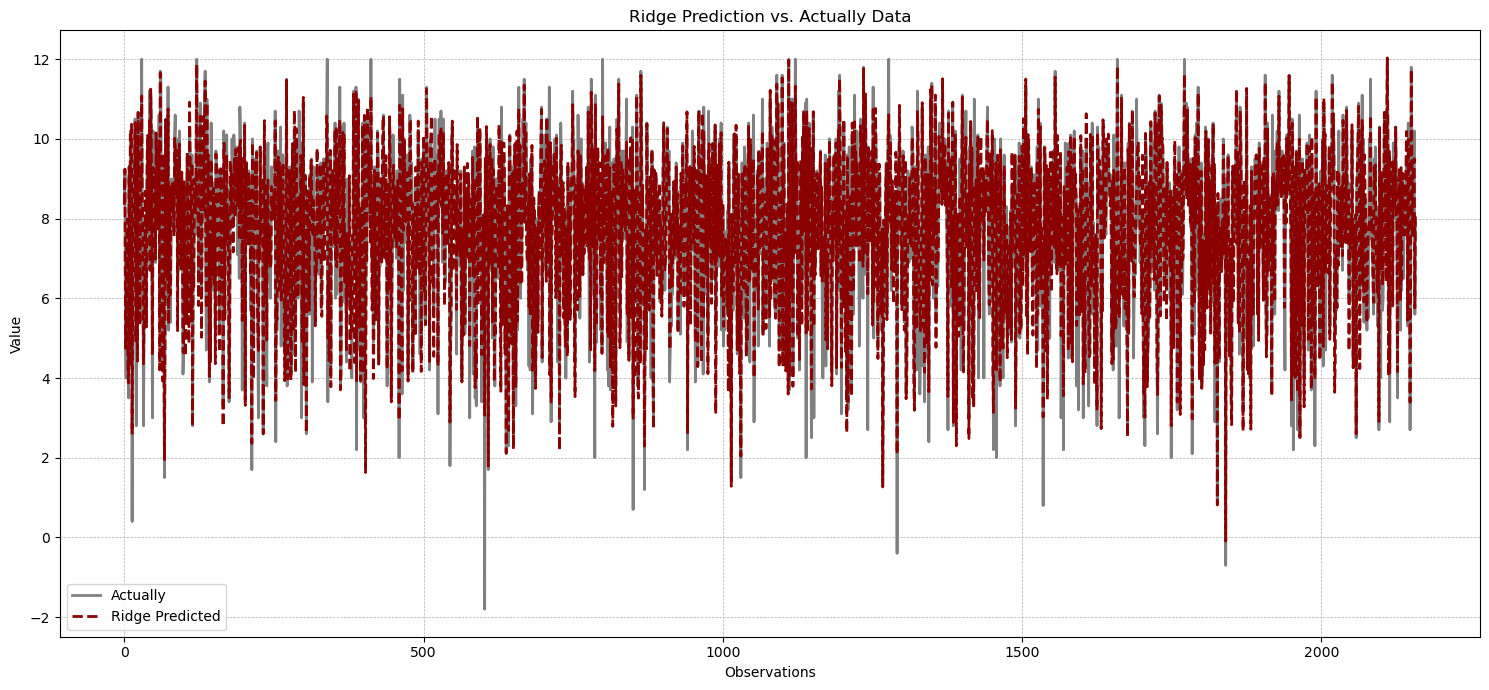

In [88]:
# Plot Ridge predictions
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Actually', color='gray', linewidth=2)
plt.plot(x_axis, predictions_best_grid_Ridge, label='Ridge Predicted', color='darkred', linestyle='--', linewidth=2)
plt.title('Ridge Prediction vs. Actually Data')
plt.xlabel('Observations')
plt.ylabel('Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Coefficients for Ridge

In [89]:
# Use coefficients from the optimal Lasso model and create DataFrame
Ridge_coefficients = best_grid_Ridge.coef_

coeff_df_Ridge = pd.DataFrame(Ridge_coefficients, Input_values_list, columns=['Coefficient'])
coeff_df_Ridge = coeff_df_Ridge.sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)

# Display the top and bottom 5 rows 
top_5 = coeff_df_Ridge.head()
bottom_5 = coeff_df_Ridge.tail()
top_and_bottom_5 = pd.concat([top_5, bottom_5])
top_and_bottom_5

,Coefficient
Moving_Average_GPA,1.925007
Fremmødte,-0.710908
Antal bestået,0.516655
Antal tilmeldte,0.245006
Year,-0.035677
"Point( ECTS )_12,5",0.001689
Mulighed for GRØN DYST deltagelse_Ikke oplyst,-0.001644
Evalueringsform_Mundtlig eksamen,0.001271
Point( ECTS )_5,-0.001191
Mulighed for GRØN DYST deltagelse_Ja,-0.000533


## Random Forrest Regressor

In [90]:
# Establish a baseline prediction to assess if the ML model provides improvement
baseline_preds = 7

# Calculate and display (average) baseline errors
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  1.86


In [98]:
# Create a Random Forest model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)

# Train the Random Forest model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=1)

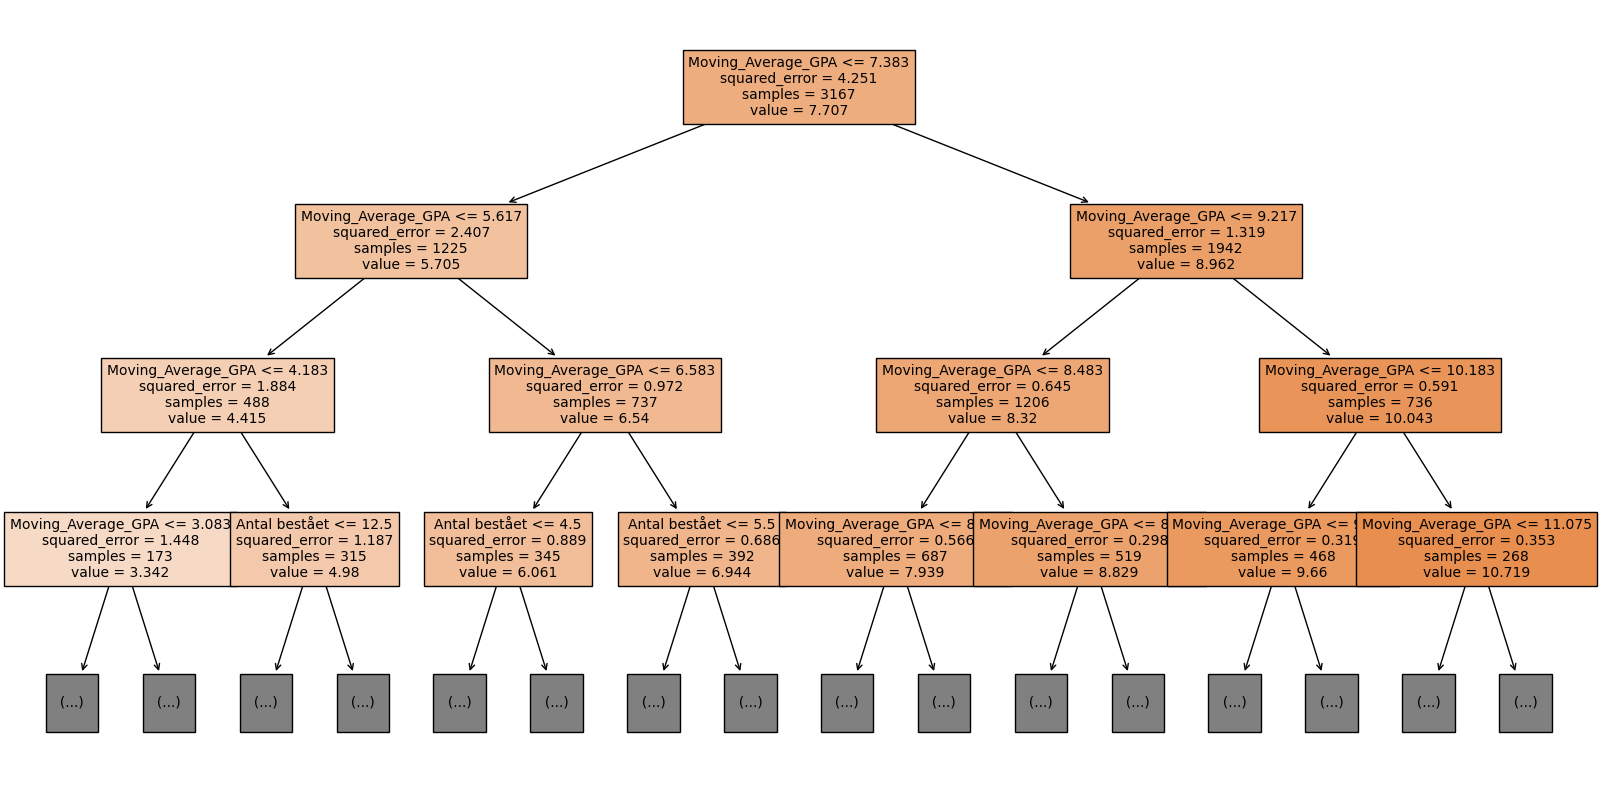

In [99]:
# Select a single decision tree from the Random Forest (using the first tree)
tree = rf.estimators_[0]

# Plot the selected decision tree with a maximum depth of 3 for clarity
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=Input_values_list, max_depth=3, fontsize=10)
plt.show()

In [100]:
# Make predictions on the test data using the trained Random Forest model
predictions = rf.predict(test_features)

# Evaluate the accuracy of the predictions against the true test labels
accuracy(predictions,test_labels)

MAE: 0.49941 grades.
MAPE: 8.63968 %.
Accuracy: 91.36032 %.
MSE: 0.52246


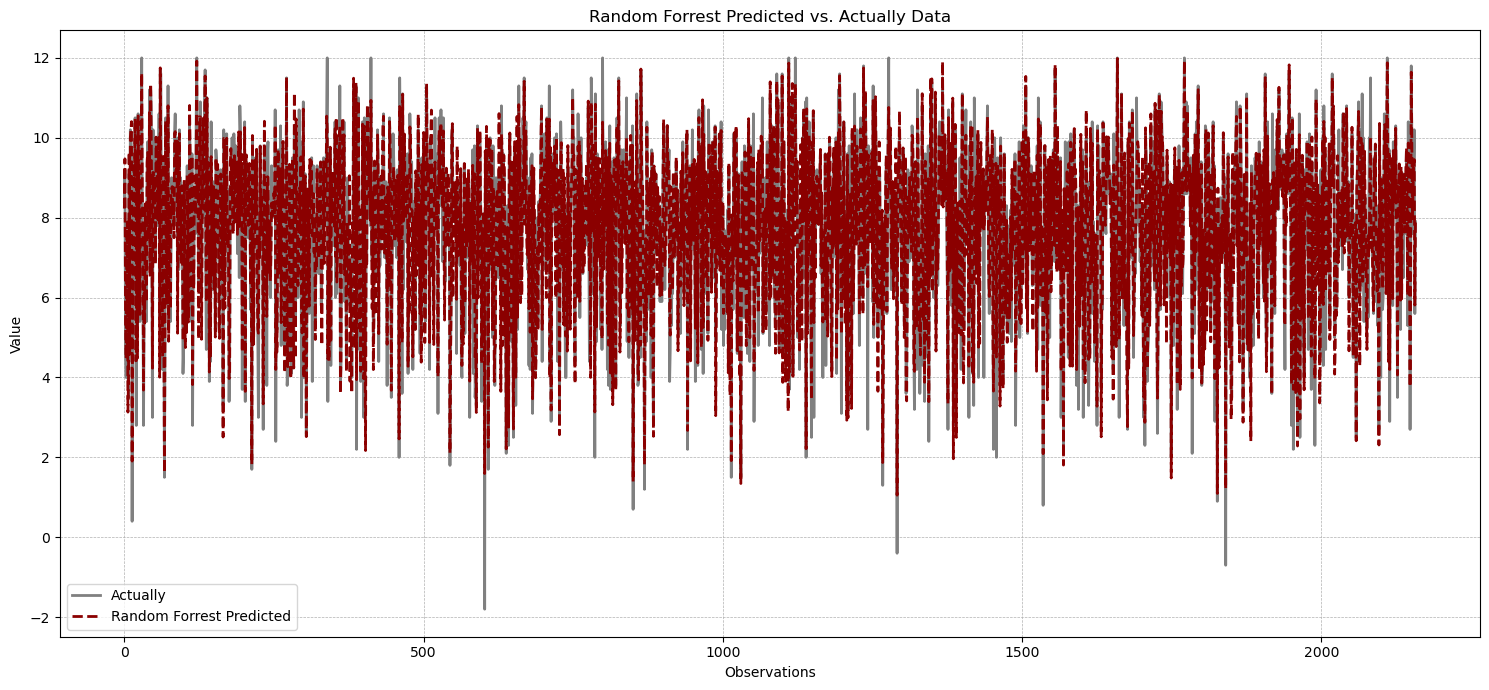

In [97]:
# Plot Random Forest predictions
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Actually', color='gray', linewidth=2)
plt.plot(x_axis, predictions, label='Random Forrest Predicted', color='darkred', linestyle='--', linewidth=2)
plt.title('Random Forrest Predicted vs. Actually Data')
plt.xlabel('Observations')
plt.ylabel('Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()